# Importar librerias

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Lecturas de datos

In [2]:
df_completo = pd.read_csv('../data/2022.csv')
df_completo.head()


,CLIENTEID,MES,MES_INFORMACION,MES_INFO_12M_AUX,Score_1,Number_of_trades,Number_of_trades_opened_in_past_12_months,Number_of_trades_opened_in_past_24_months,Months_since_oldest_account_opened,Months_since_most_recent_account_opened,...,Ratio_of_current_balance_to_high_credit_credit_limit_on_mortgage_accounts,Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_personal_finance_accounts,Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_revolving_accounts,Ratio_of_total_current_balance_to_high_credit_credit_limit_for_all_retail_trades,Number_of_inquiries,Number_or_inquiries_in_last_6_months,Months_since_most_recent_inquiry,MES_INFO_12,EVER30_12M,DAYS_OFF
0,1839,202202,202201,2023-01-01,668.0,26,1,2,171,2,...,NaN,99.8,98.6,NaN,2,1,2.0,202301,0,-11.0
1,1839,202203,202202,2023-02-01,669.0,26,1,2,172,3,...,NaN,98.4,98.4,NaN,2,1,3.0,202302,0,-11.0
2,1839,202204,202203,2023-03-01,669.0,25,1,2,173,4,...,NaN,96.7,98.5,NaN,2,1,4.0,202303,0,-8.0
3,1839,202205,202204,2023-04-01,669.0,25,1,2,174,5,...,NaN,95.2,98.6,NaN,2,1,5.0,202304,0,-6.0
4,1839,202206,202205,2023-05-01,671.0,25,1,2,175,6,...,NaN,93.5,99.0,NaN,2,1,6.0,202305,0,-3.0


# Lectura de catalogos

In [41]:
revolving = pd.read_csv('../data/revolving.csv')
installment = pd.read_csv('../data/installment.csv')
credit_activity = pd.read_csv('../data/credit_activity.csv')
delinquency = pd.read_csv('../data/delinquency.csv')
credit_utilization = pd.read_csv('../data/credit_utilization.csv')
#otros = pd.read_csv('../data/Otros.csv')

# Filtrado de población general

In [38]:
# Filtro poblacion
df = df_completo[ (df_completo['DAYS_OFF'] <= 14)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365408 entries, 0 to 407534
Columns: 188 entries, CLIENTEID to DAYS_OFF
dtypes: float64(45), int64(142), object(1)
memory usage: 526.9+ MB


# Carga de catalogos y variables

In [42]:
# Creación de dataframes
df_revolvente = df[revolving['Variable']]
df_instalment = df[installment['Variable']]
df_credit_activity = df[credit_activity['Variable']]
df_delinquency = df[delinquency['Variable']]
df_credit_utilization = df[credit_utilization['Variable']]


In [43]:
dataframes = {
    "revolving": df_revolvente,
    "installment": df_instalment,
    "credit_activity": df_credit_activity,
    "delinquency": df_delinquency,
    "credit_utilization": df_credit_utilization
}


In [44]:
predictions = []
auc_scores = {}
y_true_global = None
id_columns = ["CLIENTEID", "MES_INFORMACION"]  # ahora hay dos columnas clave
target_column = "EVER30_12M"

# Entrenamiento y predicción por categoría
for name, df in dataframes.items():
    if df.empty:
        continue

    # Resetear índice para evitar errores al indexar
    df = df.reset_index(drop=True)

    # Crear identificador único combinando CLIENTEID y MES_INFORMACION
    df["ID_UNICO"] = df["CLIENTEID"].astype(str) + "_" + df["MES_INFORMACION"].astype(str)

    features = df.drop(columns=id_columns + [target_column, "ID_UNICO"])
    target = df[target_column]
    ids = df["ID_UNICO"]

    # División de datos
    X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
        features, target, ids, test_size=0.3, random_state=42
    )

    # Entrenamiento del modelo
    model = xgb.XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    # Predicción y cálculo de AUC
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores[name] = auc

    # Guardar predicciones junto con ID_UNICO
    pred_df = pd.DataFrame({
        "ID_UNICO": id_test.values,
        f"pred_{name}": y_pred_proba
    })
    predictions.append(pred_df)

    # Guardar verdad verdadera (solo una vez)
    if y_true_global is None:
        y_true_global = pd.DataFrame({
            "ID_UNICO": id_test.values,
            target_column: y_test.values
        })



In [45]:
# Unimos las predicciones
df_preds = y_true_global.copy()
for pred in predictions:
    df_preds = df_preds.merge(pred, on="ID_UNICO", how="left")

# Modelo ensamble
X_ensemble = df_preds.drop(columns=["ID_UNICO", target_column])
y_ensemble = df_preds[target_column]

X_train_ens, X_test_ens, y_train_ens, y_test_ens, id_train_ens, id_test_ens = train_test_split(
    X_ensemble, y_ensemble, df_preds["ID_UNICO"], test_size=0.3, random_state=42
)

ensemble_model = xgb.XGBClassifier(eval_metric='logloss')
ensemble_model.fit(X_train_ens, y_train_ens)
y_ens_pred = ensemble_model.predict_proba(X_test_ens)[:, 1]

auc_scores["ensemble"] = roc_auc_score(y_test_ens, y_ens_pred)

In [46]:
pd.DataFrame.from_dict(auc_scores, orient="index", columns=["AUC_ROC"])

,AUC_ROC
revolving,0.694218
installment,0.751162
credit_activity,0.705671
delinquency,0.657197
credit_utilization,0.728401
ensemble,0.809661


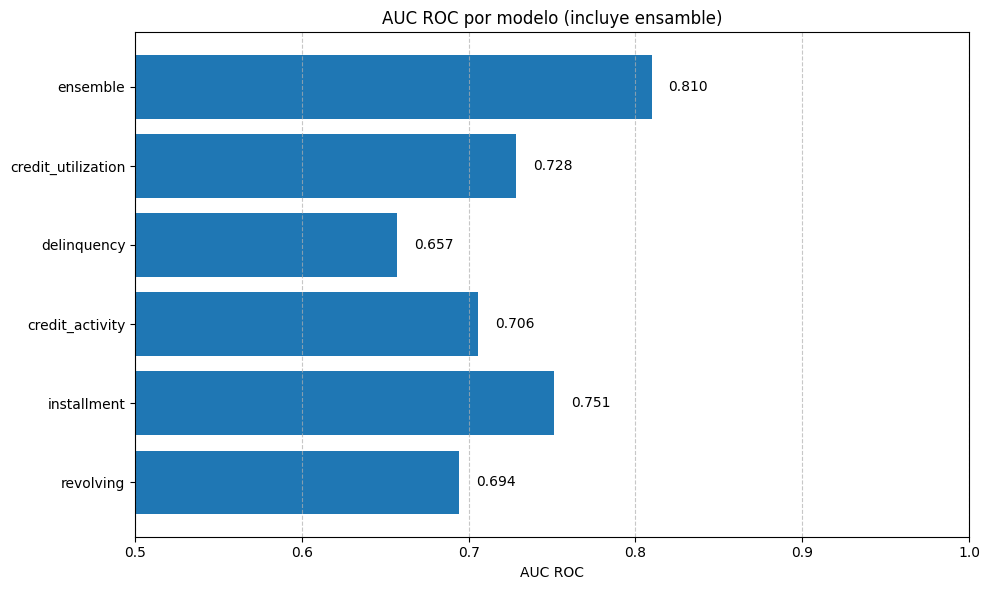

In [47]:
import matplotlib.pyplot as plt

# Convertimos a listas
model_names = list(auc_scores.keys())
auc_values = list(auc_scores.values())

# Graficamos
plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, auc_values)
plt.xlabel('AUC ROC')
plt.title('AUC ROC por modelo (incluye ensamble)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0.5, 1.0)

# Etiquetas en cada barra
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center')

plt.tight_layout()
plt.show()


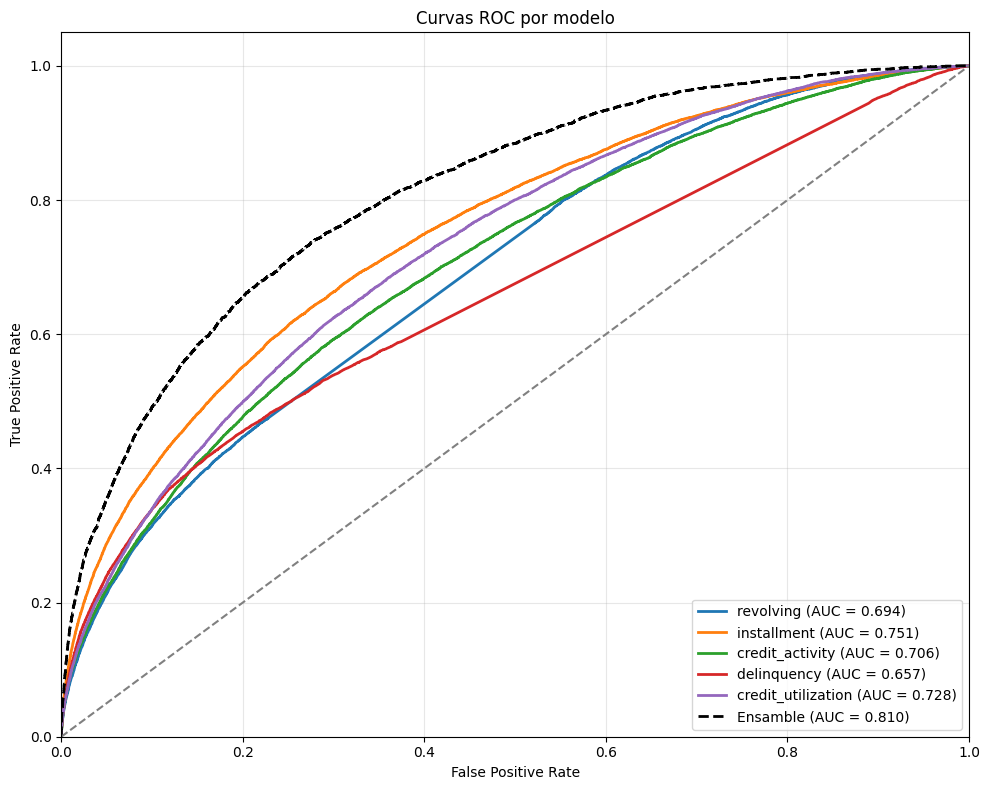

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Recorremos las predicciones
for pred_df in predictions:
    # Extraemos nombre del modelo desde la columna 'pred_{modelo}'
    model_name = [col for col in pred_df.columns if col.startswith("pred_")][0].replace("pred_", "")
    
    # Real y predicho
    y_true = y_true_global.set_index("ID_UNICO")[target_column].loc[pred_df["ID_UNICO"]]
    y_score = pred_df[f"pred_{model_name}"]

    # Calculamos curva ROC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Graficamos
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.3f})")

# ROC para el ensamble
y_true_ens = y_test_ens
fpr_ens, tpr_ens, _ = roc_curve(y_true_ens, y_ens_pred)
roc_auc_ens = auc(fpr_ens, tpr_ens)
plt.plot(fpr_ens, tpr_ens, lw=2, linestyle='--', label=f"Ensamble (AUC = {roc_auc_ens:.3f})", color='black')

# Estética del gráfico
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # línea aleatoria
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC por modelo')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [47]:
# Copiamos la verdad verdadera y unimos todas las predicciones individuales
df_full = y_true_global.copy()

for pred in predictions:
    df_full = df_full.merge(pred, on="ID_UNICO", how="left")

# Asignar predicciones del ensamble para todas las observaciones
df_full["pred_ensemble"] = ensemble_model.predict_proba(X_ensemble)[:, 1]

df_full["MES_INFORMACION"] = df_full["ID_UNICO"].str[-6:]
# Mostramos el resultado
df_full.head(20)




,ID_UNICO,EVER30_12M,pred_revolving,pred_installment,pred_ensemble,MES_INFORMACION
0,4633909_202212,0,0.179189,0.070517,0.059066,202212
1,2522960_202201,1,0.285029,0.517277,0.611539,202201
2,1858518_202212,0,0.070644,0.189897,0.080183,202212
3,2978551_202210,0,0.204788,0.180596,0.138161,202210
4,4545410_202207,0,0.156254,0.088544,0.045285,202207
5,3077558_202205,0,0.040835,0.069892,0.011941,202205
6,3005314_202212,0,0.132390,0.314428,0.240535,202212
7,4744630_202210,1,0.144324,0.176408,0.268449,202210
8,4689904_202206,1,0.200780,0.108983,0.129819,202206
9,4508804_202201,1,0.192931,0.316777,0.288117,202201


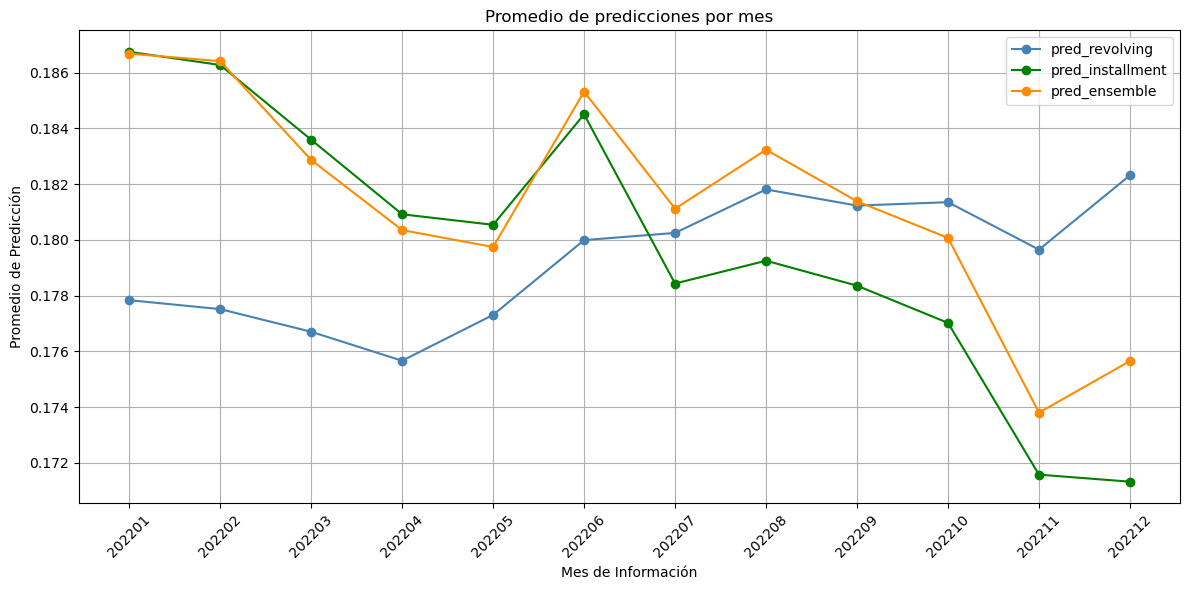

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegúrate de que MES_INFORMACION esté como string
df_full["MES_INFORMACION"] = df_full["MES_INFORMACION"].astype(str)

# Agrupamos por MES_INFORMACION y calculamos promedios
df_mean = df_full.groupby("MES_INFORMACION")[["pred_revolving", "pred_installment", "pred_ensemble"]].mean().reset_index()

# Crear la figura
plt.figure(figsize=(12, 6))

# Colores por serie
colores = {
    "pred_revolving": "steelblue",
    "pred_installment": "green",
    "pred_ensemble": "darkorange"
}

# Graficar cada línea con puntos y etiquetas
for col in ["pred_revolving", "pred_installment", "pred_ensemble"]:
    plt.plot(df_mean["MES_INFORMACION"], df_mean[col], marker='o', label=col, color=colores[col])
    

# Personalizar gráfica
plt.title("Promedio de predicciones por mes")
plt.xlabel("Mes de Información")
plt.ylabel("Promedio de Predicción")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
